# HOW TO FINE TUNE BERT FOR SPAM CLASIFICATION
**Important information**: Model was trained with A100 GPU
### Les't first download packages

In [ ]:
!pip install -q transformers==4.51.3
!pip install -q kaggle==1.7.4.2
!pip install -q dill==0.3.8
!pip install -q datasets==3.5.0

### Let's import packages for data processing, BERT model, and analysis

In [ ]:
import torch
import shutil
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import BertForSequenceClassification, BertTokenizerFast, Trainer, TrainingArguments
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

### Use Kaggle API token to download datasets for training

You can create an account in Kaggle and download the file kaggle.json into your local computer. Then you can upload it here.

In [ ]:
from google.colab import files
files.upload()
!mkdir /.kaggle
!mv kaggle.json /.kaggle
!mv /.kaggle /root/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


### Let's download datasets
For training our BERT model we will use 3 sources:


*   Lingspam dataset
*   Spamassassin dataset
*   sms-spam-collection



In [ ]:
!kaggle datasets download -d mandygu/lingspam-dataset
!kaggle datasets download -d uciml/sms-spam-collection-dataset
!kaggle datasets download -d bertvankeulen/spamassassin-spam
!unzip lingspam-dataset.zip
!unzip spamassassin-spam.zip
!unzip sms-spam-collection-dataset.zip
!rm -rf lingspam-dataset.zip
!rm -rf sms-spam-collection-dataset.zip
!rm -rf spamassassin-spam.zip

Dataset URL: https://www.kaggle.com/datasets/mandygu/lingspam-dataset
License(s): unknown
Dataset URL: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset
License(s): unknown
Dataset URL: https://www.kaggle.com/datasets/bertvankeulen/spamassassin-spam
License(s): apache-2.0
Archive:  lingspam-dataset.zip
  inflating: messages.csv            
Archive:  spamassassin-spam.zip
  inflating: SA_SubTxt_fn.csv        
Archive:  sms-spam-collection-dataset.zip
  inflating: spam.csv                


### Functions for data processing

In [ ]:
def load_model_and_tokenizer(model_path_or_name: str):
    model = BertForSequenceClassification.from_pretrained(model_path_or_name)
    tokenizer = BertTokenizerFast.from_pretrained(model_path_or_name)
    return model, tokenizer

def process_data(data, tokenizer, column='message', padding=True,
                 truncation=True):
    return tokenizer(data[column], padding=padding, truncation=truncation)

def removeUrlAndHtml(df, column='message'):
    regexes = [
        r"https?://\S+|www\.\S+", r"<[^>]>"
    ]

    for reg in regexes:
        df[column] = df[column].str.replace(reg, "", regex=True)
    return df

def preprocess_data(file_mapping, test_size=0.3):
    df_concat = pd.DataFrame(columns=['message','label'])
    for file, conf in file_mapping.items():
        df = pd.read_csv(file, encoding=conf['encoding'], on_bad_lines='skip',
                          engine='python')
        df.rename(columns=conf['columns'], inplace=True)

        if 'map' in conf:
            for column, value_mapping in conf['map'].items():
                df[column] = df[column].map(value_mapping)
        if 'regex' in conf:
            for column, regex_exp in conf['regex'].items():
                df[column] = df[column].str.replace(regex_exp, "", regex=True)

        print(f"Dataset {file} has {len(df)} records.")
        df_concat = pd.concat([df_concat, df[list(conf['columns'].values())]])

    print(f"Total amount of records in consolidated dataset is: \
        {len(df_concat)}")

    # Let's remove urls and html tags
    df_concat = removeUrlAndHtml(df_concat)
    print(f"Total amount of records in consolidated dataset is after cleaning \
    urls and html tags: {len(df_concat)}")

    dataset = Dataset.from_pandas(df_concat)
    dataset = dataset.train_test_split(test_size=test_size)
    return dataset['train'], dataset['test']

def prepare_dataset(dataset, tokenizer):
    dataset = dataset.map(lambda x: process_data(x, tokenizer), batched=True,
                          batch_size=len(dataset))
    dataset.set_format(type='torch', columns=['input_ids', 'attention_mask',
                                              'label'])
    return dataset

### Functions for training

In [ ]:
def train(model, train_dataset, output_dir='./results', log_dir='./logs',
          epochs=10, batch_size=16):
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=epochs,
        per_device_train_batch_size=batch_size,
        warmup_steps=500,
        weight_decay=0.01,
        eval_strategy="no",
        logging_dir=log_dir,
        # fp16=True,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
    )

    trainer.train()

    return trainer

### Functions for evaluation

In [ ]:
def evaluate(trainer, test_dataset):
    predictions = trainer.predict(test_dataset)
    predicted_labels = predictions.predictions.argmax(axis=-1)
    true_labels = test_dataset['label'].numpy()

    print(classification_report(true_labels, predicted_labels))

    cm = confusion_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["HAM", "SPAM"])
    disp.plot()

### Main Workflow

Dataset ./messages.csv has 2893 records.
Dataset ./spam.csv has 5572 records.
Dataset ./SA_SubTxt_fn.csv has 6046 records.
Total amount of records in consolidated dataset is:         14511
Total amount of records in consolidated dataset is after cleaning     urls and html tags: 14511


Map:   0%|          | 0/4354 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3366
           1       0.99      0.99      0.99       988

    accuracy                           1.00      4354
   macro avg       1.00      1.00      1.00      4354
weighted avg       1.00      1.00      1.00      4354



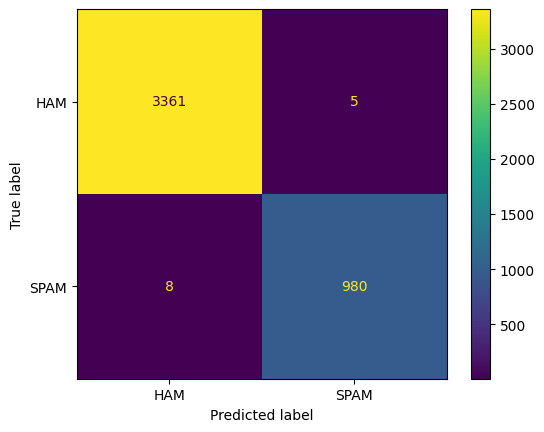

In [ ]:
def main(train_new_model=True):
    file_mapping = {
        './messages.csv':
        {
            'columns': {
                'label': 'label',
                'message': 'message',
            },
            'encoding': 'utf-8',
        },
        './spam.csv':
        {
            'columns': {
                'v1': 'label',
                'v2': 'message',
            },
            'encoding': 'latin-1',
            'map': {
                'label': {
                    'ham': 0,
                    'spam': 1,
                }
            }
        },
        './SA_SubTxt_fn.csv':
        {
            'columns': {
                'label': 'label',
                'data': 'message',
            },
            'encoding': 'utf-8',
            'regex': {
                'message': r"^\[|\]$"
            },
        }
    }

    if train_new_model:

        test_size = 0.3
        model_path = 'bert-base-uncased'  # Pretrained model base
        model, tokenizer = load_model_and_tokenizer(model_path)

        train_set, test_set = preprocess_data(file_mapping, test_size)

        train_set = prepare_dataset(train_set, tokenizer)
        test_set = prepare_dataset(test_set, tokenizer)

        trainer = train(model, train_set)

        # Save model and tokenizer
        trainer.save_model('./saved_model')
        tokenizer.save_pretrained('./saved_model')

        # Zip the result directory
        shutil.make_archive('saved_model', 'zip', './saved_model')
        files.download('saved_model.zip')

    else:
        # Load already saved model
        model, tokenizer = load_model_and_tokenizer('./saved_model')

        _, test_set = preprocess_data(file_mapping)
        test_set = prepare_dataset(test_set, tokenizer)

        trainer = Trainer(model=model)  # No need for training arguments when just evaluating

    # Evaluate in both cases
    evaluate(trainer, test_set)
main(False)